# Import Libraries

In [1]:
import re
import os
import io
import spacy
import string
import numpy as np
import pandas as pd

# Gensim
import gensim
from gensim import models
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import warnings
warnings.filterwarnings('ignore')


# Read and Prepare Dataset

In [2]:
dataset = pd.read_csv("processedcovidvaccinereact.csv", index_col=0)
dataset.shape

(126250, 7)

In [3]:
dataset = dataset.dropna() # drop null values
dataset.shape

(125829, 7)

In [4]:
dataset.head(5)

,TweetDate,TweetText,CleanedTweet,TweetAuthor,TweetLocation,AllHashtags,Country
0,2021-03-17 23:59:34,The only way #COVID19 can mutate with variants...,onli way mutat variant viru replic host peopl ...,kemsunde,Unknown,"['COVID19', 'CovidVaccine', 'GetTheFactsGetThe...",Unknown
1,2021-03-17 23:59:20,I've now officially had my 1st dose of the #Co...,ive offici dose covidvaccin definit worth driv...,ManeckiN,The Wild Western Wastes,"['CovidVaccine', 'COVID19', 'PfizerVaccine', '...",Unknown
2,2021-03-17 23:58:31,@hendopolis Imagine if the #Brexit referendum ...,hendopoli imagin brexit referendum held secret...,raymasseytweets,England,"['Brexit', 'EU', 'TrueColours', 'Impfstoff', '...",United Kingdom
3,2021-03-17 23:58:03,@EICostheta @RicBarraArch1 @insiders Yep. The ...,eicostheta insid yep liarsnparasit veri narrow...,MikeFitzAU,Mudjimba,"['LiarsNParasites', 'CovidVaccine']",Australia
4,2021-03-17 23:57:37,This sounds like an important topic for @NickS...,thi sound like import topic nicksawyermd tnich...,stephjantzen,Greater Sacramento,"['FiresideChat', 'CovidVaccine']",Brazil


In [5]:
text_data = dataset["CleanedTweet"]  # select cleaned tweets column
#text_data = text_data[:100]

In [6]:
text_data =  [text.split() for text in text_data]  # tokenize dataset

### Make Bigrams for LDA Model

In [7]:
# Build the bigram models
bigram = gensim.models.Phrases(text_data, min_count=5, threshold=100) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

text_data = [bigram_mod[doc] for doc in text_data]

# Build Dictionary

In [8]:
# make dictionary of complete corpus
dictionary_LDA = corpora.Dictionary(text_data)
# filter tokens below frequency of 3 words
dictionary_LDA.filter_extremes(no_below=3)
# index to words 
corpus = [dictionary_LDA.doc2bow(tok) for tok in text_data]

# Build LDA Model
# Compute Coherence and Preplexity
# Choose optimal number of topics

In [9]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    
    topics_list = [20, 25, 30]
    coherence_values = []
    perplexity_val = []
    model_list = []
    for num_topics in topics_list:
        model = models.LsiModel(corpus, num_topics=num_topics, id2word=dictionary_LDA, onepass=False)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=text_data, dictionary=dictionary_LDA, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

# Train LDA Model

In [10]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary_LDA, corpus=corpus, texts=text_data, start=2, limit=40, step=6)

# Plot Coherence Scores

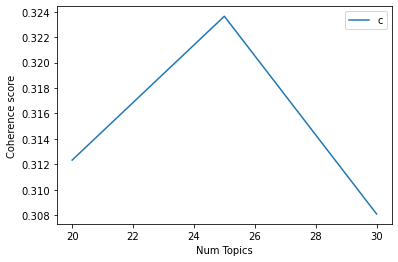

In [11]:
# Show graph
import matplotlib.pyplot as plt

topics_list = [20,25,30]
plt.plot(topics_list, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Display Results

In [12]:
# Print the coherence scores
topics_list = [20,25,30]
for m, cv in zip(topics_list, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 20  has Coherence Value of 0.3123
Num Topics = 25  has Coherence Value of 0.3236
Num Topics = 30  has Coherence Value of 0.3081



## Train Model with Best number of topics

In [21]:
best_topic_number = 25
best_model = models.LsiModel(corpus, num_topics=best_topic_number, id2word=dictionary_LDA, onepass=False)
        

In [22]:
coherencemodel = CoherenceModel(model=best_model, texts=text_data, dictionary=dictionary_LDA, coherence='c_v')
coherence_score = coherencemodel.get_coherence()
print("Num Topics =", best_topic_number, " has Coherence Value of", round(coherence_score, 4))
        

Num Topics = 25  has Coherence Value of 0.323


In [23]:
# display all topics with weight of all keywords
for i,topic in best_model.show_topics(formatted=True, num_topics=best_topic_number, num_words=20):
    print(str(i)+": "+ topic)
    print()

0: 0.752*"vaccin" + 0.394*"covidvaccin" + 0.346*"rt" + 0.180*"get" + 0.120*"thi" + 0.087*"covid" + 0.078*"first" + 0.078*"today" + 0.077*"amp" + 0.072*"peopl" + 0.069*"got" + 0.064*"dose" + 0.062*"ha" + 0.052*"one" + 0.050*"shot" + 0.050*"astrazeneca" + 0.049*"thank" + 0.042*"year" + 0.040*"wa" + 0.040*"receiv"

1: 0.610*"vaccin" + -0.544*"rt" + -0.520*"covidvaccin" + -0.104*"thi" + -0.071*"ha" + -0.064*"astrazeneca" + -0.062*"amp" + -0.046*"would" + -0.040*"u" + -0.039*"today" + -0.038*"export" + -0.036*"blood_clot" + -0.032*"get" + -0.027*"india" + -0.026*"ani" + -0.026*"countri" + -0.025*"thank" + -0.025*"drericd" + -0.025*"elig" + -0.025*"ema_safeti"

2: -0.706*"rt" + 0.644*"covidvaccin" + 0.119*"get" + -0.086*"vaccin" + -0.074*"would" + 0.070*"covid" + 0.044*"shot" + -0.042*"committe_prac" + -0.042*"ema_safeti" + -0.041*"life_save" + -0.041*"davidmweissman_never" + -0.041*"maga_end" + -0.041*"imagin_leav" + -0.041*"decis" + -0.041*"support_trump" + -0.040*"maryltrump_long" + -0.04

In [24]:
# convert all probability distribution into dataframe (we are doing this to also keep topics having 0 probability)
# In other case topics having 0 probability will be misleading
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res


In [25]:
# find topic probabilities that model assign to all documents
topics = [best_model[corpus[i]] for i in range(len(text_data))]

In [26]:
# make dataframe of all document probability distribution
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=best_topic_number) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [27]:
document_topic.head(10)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.745380,-0.599246,0.807923,-0.719431,-0.563834,0.365005,-0.014708,-0.059978,-0.136796,-0.006851,...,-0.091071,-0.036055,-0.041956,0.283491,-0.119428,-0.154701,-0.134543,0.021582,0.115712,0.088122
1,0.581866,-0.560021,0.750518,0.169219,0.017492,-0.390791,0.087162,-0.032881,0.004517,-0.128756,...,0.024711,-0.129987,-0.215750,-0.047758,-0.434956,0.142159,0.249449,0.034795,-0.016693,0.226871
2,0.435289,-0.545262,0.659127,0.264830,-0.020825,0.114206,0.040842,-0.029794,-0.061965,0.018016,...,-0.024684,-0.045755,0.014430,0.112365,-0.042554,0.002099,-0.098671,0.061471,0.068242,-0.028873
3,0.588037,-0.628853,0.702723,0.108770,0.101254,0.108396,-0.107394,0.967489,0.097686,0.075201,...,0.026354,-0.018007,0.073454,0.088959,-0.010309,0.008246,-0.078697,-0.034722,-0.051027,-0.042390
4,0.636302,-0.743064,0.629203,-0.201789,0.763053,0.302778,0.737042,-0.105150,0.247800,0.065544,...,-0.061668,0.431257,-0.142533,-0.140545,-0.022400,0.047634,-0.066697,0.434771,0.148771,-0.146122
5,1.276102,0.081429,0.656303,0.440128,-0.010729,0.237055,0.095880,-0.030099,-0.067656,0.331881,...,-0.042690,-0.020399,0.032459,0.083754,-0.002718,-0.106454,-0.021837,0.070760,0.018394,0.044582
6,2.121016,0.597414,0.574525,0.372497,-0.031879,0.354499,0.052844,0.002995,-0.297192,-0.109098,...,-0.012727,-0.151775,0.069335,-0.331549,0.026895,0.071401,0.042695,-0.059602,-0.026625,-0.112018
7,1.317673,-0.021401,0.539976,0.391748,0.059001,0.329556,-0.077014,-0.175665,0.621461,0.106763,...,0.073245,-0.053921,0.090244,0.341394,-0.035152,0.013265,0.095606,-0.728424,-0.361181,-0.162685
8,1.433395,-0.094517,0.652008,0.366499,0.164377,0.385998,-0.163372,0.923256,0.080712,-1.042399,...,0.107504,0.067172,-0.010320,0.029355,0.005523,-0.086461,-0.049869,0.044352,-0.032545,-0.150194
9,0.246041,-0.081032,0.090475,-0.020413,0.007940,-1.006550,0.027999,0.004320,0.051011,-0.390317,...,0.283103,0.086193,0.068392,-0.185567,0.329446,-0.009859,0.142741,0.058022,-0.219726,0.074130


# Calculate and Find Keywords in each Document


In [28]:
def format_topics_sentences(lsimodel=best_model, corpus=corpus, texts=text_data):
    # Init output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic in each document
    for i, row in enumerate(lsimodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lsimodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Per_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(lsimodel=best_model, corpus=corpus, texts=text_data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.8079,"rt, covidvaccin, get, vaccin, would, covid, sh...","[onli, way, mutat, variant, viru, replic, host..."
1,1,2.0,0.7505,"rt, covidvaccin, get, vaccin, would, covid, sh...","[ive, offici, dose, covidvaccin, definit, wort..."
2,2,2.0,0.6591,"rt, covidvaccin, get, vaccin, would, covid, sh...","[hendopoli, imagin, brexit, referendum, held, ..."
3,3,7.0,0.9675,"amp, thi, get, would, astrazeneca, covidvaccin...","[eicostheta, insid, yep, liarsnparasit, veri, ..."
4,4,4.0,0.7631,"thi, get, take, amp, drericd, cant_believ, gar...","[thi, sound, like, import, topic, nicksawyermd..."
5,5,0.0,1.2761,"vaccin, covidvaccin, rt, get, thi, covid, firs...","[studi, show, fdaapprov, vaccin, protect, curr..."
6,6,0.0,2.1210,"vaccin, covidvaccin, rt, get, thi, covid, firs...","[updat, back, park, lot, peopl, line, vaccin, ..."
7,7,0.0,1.3177,"vaccin, covidvaccin, rt, get, thi, covid, firs...","[german, headlin, angela_merkel, refus, astraz..."
8,8,0.0,1.4334,"vaccin, covidvaccin, rt, get, thi, covid, firs...","[mask, ha, slip, eu, savag, aw, vaccin, block,..."
9,9,19.0,0.3294,"shot, got, first, thank, dose, receiv, im, tod...","[chicagoan, age, older, receiv, first, dose, w..."
